In [1]:
import sys
sys.path.append('..')

import numpy as np
import os
from time import time
from collections import Counter
import random
from matplotlib import pyplot as plt

from lib.data_utils import shuffle
#from lib.config import data_dir

def mnist():
    fd = open(os.path.join('train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trX = loaded[16:].reshape((60000,28*28)).astype(float)

    fd = open(os.path.join('train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trY = loaded[8:].reshape((60000))

    fd = open(os.path.join('t10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teX = loaded[16:].reshape((10000,28*28)).astype(float)

    fd = open(os.path.join('t10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teY = loaded[8:].reshape((10000))
    
    trY = np.asarray(trY)
    teY = np.asarray(teY)

    return trX, teX, trY, teY

def mnist_with_valid_set():
    trX, teX, trY, teY = mnist()

    trX, trY = shuffle(trX, trY)
    vaX = trX[50000:]
    vaY = trY[50000:]
    trX = trX[:50000]
    trY = trY[:50000]

    return trX, vaX, teX, trY, vaY, teY

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '13944' (I am process '10716')
DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmp6clmvm/265abc51f7c376c224983485238ff1a5.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmp6clmvm/265abc51f7c376c224983485238ff1a5.exp

Using gpu device 0: Quadro K2000 (CNMeM is disabled, cuDNN 5005)


In [2]:
#data_dir='/home/dcgan_code-master/mnist'
import theano
theano.config.floatX='float32'
theano.config.floatX

'float32'

In [3]:
trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()
import cv2
data2=np.zeros((100,64*64))
trX=trX/255
trX[trX>=0.5]=1
trX[trX<=0.5]=0
%matplotlib inline
for i in range(100):
    XXX=trX[i,:].reshape(28,28)
    temp=cv2.resize(XXX,(64,64))
    temp[temp>=0.5]=1
    temp[temp<=0.5]=0
    data2[i,:]=temp.reshape(-1)

In [4]:
import numpy as np
import theano
import theano.tensor as tensor
from theano.tensor.signal.pool import pool_2d
from theano.tensor.nnet import conv2d

def conv( x, w, b=None ):
    s = int(np.floor(w.get_value().shape[-1]/2.))
    z = conv2d(x, w, border_mode='full')[:, :, s:-s, s:-s]
    if b is not None:
        z += b.dimshuffle('x', 0, 'x', 'x')
    
    return z
        
def max_pool( x, size, ignore_border=False ):
    return pool_2d( x, size, ignore_border=ignore_border )

def rectify( x ):
    return (x + abs(x)) / 2.0

def batchnorm( x, g=None, b=None, eps=1e-8 ):
    if x.ndim == 4:
        m = tensor.mean(x, axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')
        v = tensor.mean(tensor.sqr(x - m), 
                          axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')

        x = (x - m) / tensor.sqrt( v + eps )
        if g is not None and b is not None:
            x = x*g.dimshuffle('x', 0, 'x', 'x') + b.dimshuffle('x', 0, 'x', 'x')

    elif x.ndim == 2:
        m = tensor.mean(x, axis=0)
        v = tensor.mean(tensor.sqr(x - m), axis=0)

        x = (x - m) / tensor.sqrt( v + eps )
        if g is not None and b is not None:
            x = x*g + b

    return x

def depool( x, factor=2 ):
    """
    This code is from 
    https://gist.github.com/kastnerkyle/f3f67424adda343fef40
    """
    output_shape = [
        x.shape[1],
        x.shape[2]*factor,
        x.shape[3]*factor
    ]
    stride = x.shape[2]
    offset = x.shape[3]
    in_dim = stride * offset
    out_dim = in_dim * factor * factor

    upsamp_matrix = tensor.zeros((in_dim, out_dim))
    rows = tensor.arange(in_dim)
    cols = rows*factor + (rows/stride * factor * offset)
    upsamp_matrix = tensor.set_subtensor(upsamp_matrix[rows, cols], 1.)

    flat = tensor.reshape(x, (x.shape[0], output_shape[0], x.shape[2] * x.shape[3]))

    up_flat = tensor.dot(flat, upsamp_matrix)
    upsamp = tensor.reshape(up_flat, (x.shape[0], output_shape[0],
                                      output_shape[1], output_shape[2]))

    return upsamp

def full_conn( x, w, b=None ):
    return tensor.dot( x, w ) + b

def leaky_rectify( x, leak=0.2 ):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x) 

In [5]:
import sys
sys.path.append('..')

import os
import json
import scipy.io
from time import time
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.externals import joblib

import math
import theano
import theano.tensor as T
from theano.sandbox.cuda.dnn import dnn_conv

from lib import activations
from lib import updates
from lib import inits
from lib.vis import grayscale_grid_vis
from lib.rng import py_rng, np_rng
from lib.ops import conv_cond_concat, deconv, dropout
from lib.theano_utils import floatX, sharedX
from lib.data_utils import OneHot, shuffle, iter_data
from lib.metrics import nnc_score, nnd_score
np.set_printoptions(threshold='nan')
#from load import mnist_with_valid_set

#trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()

#image = scipy.io.loadmat('WB_test64_GAN.mat')
#data1=np.abs(image['WB_test64_GAN']-1)

vaX= data2[0:1000]
trX= data2[0:1000]
#vaX= data2
#trX= data2
vaX = floatX(vaX)

k = 1             # # of discrim updates for each gen update
l2 = 2.5e-5       # l2 weight decay
b1 = 0.5          # momentum term of adam
nc = 1            # # of channels in image
#ny = 10           # # of classes
nbatch = 100      # # of examples in batch
npx = 64          # # of pixels width/height of images
nz = 30          # # of dim for Z
ngfc = 1024       # # of gen units for fully connected layers
ndfc = 1024       # # of discrim units for fully connected layers
ngf = 40          # # of gen filters in first conv layer
ndf = 40          # # of discrim filters in first conv layer
nx = npx*npx*nc   # # of dimensions in X
niter = 10000       # # of iter at starting learning rate
niter_decay = 0 # # of iter to linearly decay learning rate to zero
lr = 0.0002       # initial learning rate for adam
#ntrain, nval, ntest = len(trX), len(vaX), len(teX)
ntrain = len(trX)

def transform(X):
    return (floatX(X)).reshape(-1, nc, npx, npx)
    #return (floatX(X)).reshape(-1, nc, npx, npx)
def inverse_transform(X):
    X = X.reshape(-1, npx, npx)
    return X

relu = activations.Rectify()
sigmoid = activations.Sigmoid()
lrelu = activations.LeakyRectify()

bce = T.nnet.binary_crossentropy
tanh = activations.Tanh()

eifn = inits.Normal(scale=0.02)
gifn = inits.Normal(scale=0.02)
difn = inits.Normal(scale=0.02)
gain_ifn = inits.Normal(loc=1., scale=0.02)
bias_ifn = inits.Constant(c=0.)

#decoder
wd4 = gifn((nz, ndf*4*8*8), 'wd4')
bd4 = bias_ifn((ndf*4*8*8),'bd4')
bwd4 = gifn((ndf*4*8*8), 'bwd4')
bbd4 = bias_ifn((ndf*4*8*8), 'bbd4')
wd3 = gifn((ngf*4, ngf*4, 5, 5), 'wd3')
bwd3 = gain_ifn((ngf*4), 'bwd3')
bbd3 = bias_ifn((ngf*4), 'bbd3')
wd2 = gifn((ngf*2, ngf*4, 5, 5), 'wd2')
bwd2 = gain_ifn((ngf*2), 'bwd2')
bbd2 = bias_ifn((ngf*2), 'bbd2')
wd1 = gifn((ngf, ngf*2, 5, 5),'wd1')
bwd1 = gain_ifn((ngf),'bwd1')
bbd1 = bias_ifn((ngf),'bbd1')
wd0 = gifn((nc,ngf,5,5), 'wd0')
bwd = bias_ifn((nc),'bwd')

#discriminator
wg1 = difn((ndf, nc, 5, 5), 'wg1')
wg2 = difn((ndf*2, ndf, 5, 5), 'wg2')
wg3 = difn((ndf*4, ndf*2, 5, 5), 'wg3')
wg4 = difn((ndf*4, ndf*4, 5, 5), 'wg4')
wg5 = difn((ndf*4*8*8,1000), 'wg5')
bg5 = bias_ifn((1000),'bg5')
wg6 = difn((1000,1), 'wg6')
bg6 = bias_ifn((1),'bg6')
dd1 = bias_ifn((ndf),'dd1')
dd2 = bias_ifn((ndf*2),'dd2')
dd3 = bias_ifn((ndf*4),'dd3')
dd4 = bias_ifn((ndf*4),'dd4')


gen_params= [wd4, bd4, wd3, bbd3, wd2, bbd2, wd1, bbd1, wd0, bwd]
discrim_params= [wg1, wg2, wg3, wg4, wg5, bg5, wg6, bg6, dd1, dd2, dd3, dd4]


def gen(Z, wd4, bd4, wd3, bbd3, wd2, bbd2, wd1, bbd1, wd0, bwd):
    
    h5  = rectify(( full_conn( Z,  wd4, bd4 )) )
    h5_ = h5.reshape( (-1,160, 8, 8) )
    h6  = rectify(( conv( depool( h5_, factor=2 ), wd3, bbd3 )) )
    h7  = rectify(( conv( depool( h6 , factor=2 ), wd2, bbd2)) )
    h8  = rectify(( conv( depool( h7,  factor=2 ), wd1, bbd1 )) )
    x_tilde   = sigmoid( conv( h8, wd0, bwd ) )
    return x_tilde


def discrim(X, wg1, wg2, wg3, wg4, wg5, bg5, wg6, bg6, dd1, dd2, dd3, dd4):
    h1 = leaky_rectify( conv( X,  wg1, dd1 ) )
    h2 = leaky_rectify( max_pool( conv( h1, wg2, dd2 ), (2,2) ) )
    h3 = leaky_rectify( max_pool( conv( h2, wg3, dd3 ), (2,2) ) )
    h4 = leaky_rectify( max_pool( conv( h3, wg4, dd4 ), (2,2) ) )
    h4_ = h4.reshape( (-1,160*(8**2)) )
    h5 = leaky_rectify( full_conn( h4_, wg5, bg5 ) )
    h6 = sigmoid(full_conn( h5, wg6, bg6 ))
    image_feature = h3

    return h6


X = T.tensor4()
Z = T.matrix()

gX = gen(Z, *gen_params)

p_real = discrim(X, *discrim_params)
p_gen = discrim(gX, *discrim_params)

d_cost_real = bce(p_real, T.ones(p_real.shape)).mean()
d_cost_gen = bce(p_gen, T.zeros(p_gen.shape)).mean()
g_cost_d = bce(p_gen, T.ones(p_gen.shape)).mean()

d_cost = d_cost_real + d_cost_gen
g_cost = g_cost_d

cost = [g_cost, d_cost, g_cost_d, d_cost_real, d_cost_gen]

lrt = sharedX(lr)
d_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
g_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
d_updates = d_updater(discrim_params, d_cost)
g_updates = g_updater(gen_params, g_cost)
updates = d_updates + g_updates

print 'COMPILING'
t = time()
_train_g = theano.function([X, Z], cost, updates=g_updates)
_train_d = theano.function([X, Z], cost, updates=d_updates)
_gen = theano.function([Z], gX)
print '%.2f seconds to compile theano functions'%(time()-t)


#sample_zmb = floatX(np_rng.uniform(-1., 1., size=(nvis, nz)))

vaX = vaX.reshape(len(vaX), -1)    

n_updates = 0
n_check = 0
n_epochs = 0
n_updates = 0
n_examples = 0
vae_cost_error=[]
gen_cost_error=[]
dis_cost_error=[]
t = time()
iter_error=0
print 'start training......'


c:\anaconda\lib\site-packages\ipykernel\__main__.py:58: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.


COMPILING
42.05 seconds to compile theano functions
start training......


In [6]:
for epoch in range(1,2*niter):
    for imb in iter_data(trX, size=nbatch):
        imb = transform(imb)
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        if n_updates % (k+1) == 0:
            cost = _train_g(imb, zmb)
        else:
            cost = _train_d(imb, zmb)
        n_updates += 1
        n_examples += len(imb)
    g_cost = float(cost[0])
    d_cost = float(cost[1])
    if (epoch) % 10 == 0:
        print '%.0f %.4f %.4f'%(epoch, g_cost, d_cost)
#     if n_epochs > niter:
#         lrt.set_value(floatX(lrt.get_value() - lr/niter_decay))

10 1.5685 0.4261
20 7.6504 0.0009
30 2.7108 0.0823
40 4.9217 0.0077
50 6.4275 0.0016
60 7.9756 0.0004
70 7.7732 0.0004
80 7.1966 0.0008
90 6.0402 0.0025
100 5.3004 0.0052
110 5.9250 0.0027
120 6.0372 0.0024
130 6.7290 0.0012
140 7.4102 0.0006
150 7.5137 0.0006
160 7.3862 0.0006


KeyboardInterrupt: 

In [34]:
for epoch in range(220,niter):
    for imb in iter_data(trX, size=nbatch):
        imb = transform(imb)
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        if n_updates % (k+1) == 0:
            cost = _train_g(imb, zmb)
        else:
            cost = _train_d(imb, zmb)
        n_updates += 1
        n_examples += len(imb)
    g_cost = float(cost[0])
    d_cost = float(cost[1])
    if (epoch) % 10 == 0:
        print '%.0f %.4f %.4f'%(epoch, g_cost, d_cost) 

1290 0.9706 1.0144
1300 19.6223 0.7760
1310 4.3650 0.0546
1320 3.7149 0.0311
1330 4.7175 0.0227
1340 4.7810 0.0228
1350 6.4208 0.0119
1360 4.5545 0.0207
1370 5.6463 0.0101
1380 6.6635 0.0060
1390 6.5693 0.0133
1400 7.6089 0.0106
1410 7.2129 0.0097
1420 5.4662 0.0074
1430 7.2636 0.0060
1440 5.7908 0.0071
1450 5.8986 0.0049
1460 6.8036 0.0043
1470 7.7502 0.0018
1480 6.1417 0.0031
1490 7.5898 0.0012
1500 7.3943 0.0020
1510 7.6790 0.0018
1520 6.5120 0.0029
1530 8.8866 0.0014
1540 7.1895 0.0118
1550 1.8381 0.3456
1560 4.5443 0.0198
1570 4.3773 0.0199
1580 4.6394 0.0118
1590 5.2660 0.0061
1600 6.1195 0.0036
1610 6.2445 0.0033
1620 4.3183 0.0228
1630 6.4898 0.0025
1640 6.9065 0.0035
1650 7.1639 0.0017
1660 6.2991 0.0038
1670 6.9945 0.0020
1680 6.9878 0.0022
1690 8.7793 0.0008
1700 7.8526 0.0016
1710 7.1889 0.0021
1720 7.2941 0.0017
1730 6.5187 0.0025
1740 7.1071 0.0021
1750 8.2572 0.0016
1760 7.9890 0.0022
1770 7.3317 0.0021
1780 7.2688 0.0020
1790 6.3918 0.0033
1800 8.5957 0.0015
1810 7.0982

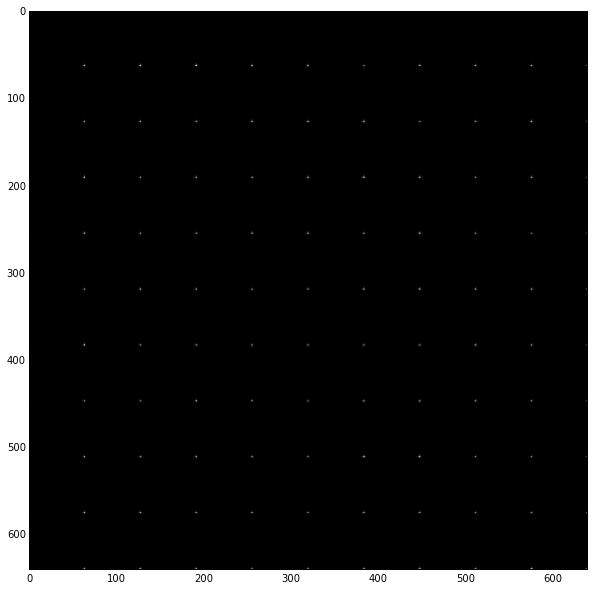

In [9]:
n = 10  # figure with 15x15 digits
digit_size = 64
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np_rng.uniform(-1., 1., size=(10, nz))
        z_sample=z_sample.astype(np.float32)
        x_decoded = _gen(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

In [8]:
_gen(np_rng.uniform(-1., 1., size=(1, nz)).astype(np.float32))

array([[[[  3.89231509e-03,   2.74420658e-04,   7.04944478e-06,
            1.26303928e-06,   1.49946672e-07,   1.36354416e-07,
            4.36543743e-08,   5.71010119e-08,   1.38301015e-08,
            3.75273395e-08,   1.38077221e-08,   2.16350617e-08,
            5.93543437e-09,   2.37067379e-08,   1.27472557e-08,
            3.34491439e-08,   1.23537438e-08,   5.58146738e-08,
            2.36439242e-08,   4.12382839e-08,   1.26677318e-08,
            5.31149809e-08,   2.92475146e-08,   7.10454700e-08,
            2.38456881e-08,   8.61048335e-08,   2.98467917e-08,
            4.03592963e-08,   1.00465112e-08,   3.36426922e-08,
            1.61083555e-08,   3.61584576e-08,   1.14711787e-08,
            4.30358149e-08,   1.58706612e-08,   2.40197426e-08,
            6.40901332e-09,   2.49611496e-08,   1.29048487e-08,
            3.26305098e-08,   1.06463025e-08,   4.21394013e-08,
            1.47933372e-08,   2.14144737e-08,   5.06731679e-09,
            1.79658155e-08,   8.10363776

In [9]:
_gen(np_rng.uniform(-1., 1., size=(1, nz)).astype(np.float32))

array([[[[  7.23565245e-05,   2.11074962e-06,   1.20995058e-09,
            1.65169031e-10,   1.10129494e-12,   3.40484151e-12,
            1.03624703e-13,   4.92137960e-13,   1.19895057e-14,
            3.09838011e-13,   1.17356500e-14,   9.14197036e-14,
            3.04895693e-15,   1.67383712e-13,   1.39679113e-14,
            2.26020483e-13,   1.25204912e-14,   6.99495800e-13,
            3.02186932e-14,   2.25272925e-13,   7.50673463e-15,
            3.43725618e-13,   2.51464380e-14,   3.23138163e-13,
            1.42183239e-14,   6.14311228e-13,   2.06326045e-14,
            1.30902979e-13,   3.57070212e-15,   1.55980385e-13,
            1.03369800e-14,   1.38948992e-13,   5.23838632e-15,
            2.46764957e-13,   7.10251653e-15,   4.58836528e-14,
            1.02516408e-15,   4.88021048e-14,   2.76290077e-15,
            4.11652388e-14,   1.49195780e-15,   8.74964028e-14,
            2.60544497e-15,   2.06496926e-14,   4.56125019e-16,
            2.64135739e-14,   1.41605338

In [97]:
XXX=trX[50].reshape(1,1, 64,64)
#XXX.dtype='float32'
XXX=XXX.astype(np.float32)
XXX.shape

(1L, 1L, 64L, 64L)

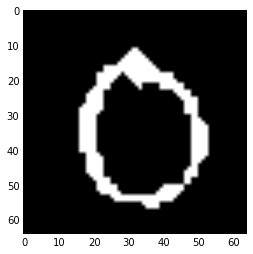

In [149]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(imb[1:2].reshape(64,64),'gray')

In [133]:
epsilon=np.random.normal(0, 0.01, (nbatch, nz))
sampling_Z = _enc(XXX)[0] + np.exp(_enc(XXX)[1] / 2) * epsilon
sampling_Z=sampling_Z.astype(np.float32)
sampling_Z[0].shape
#_gen(sampling_Z[0])

(1000L,)

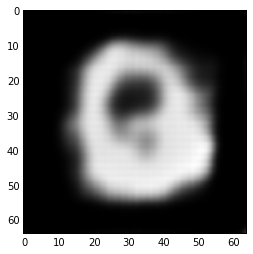

In [151]:
plt.imshow(_gen(_enc(imb[1:2])[0]).reshape(64,64),'gray')

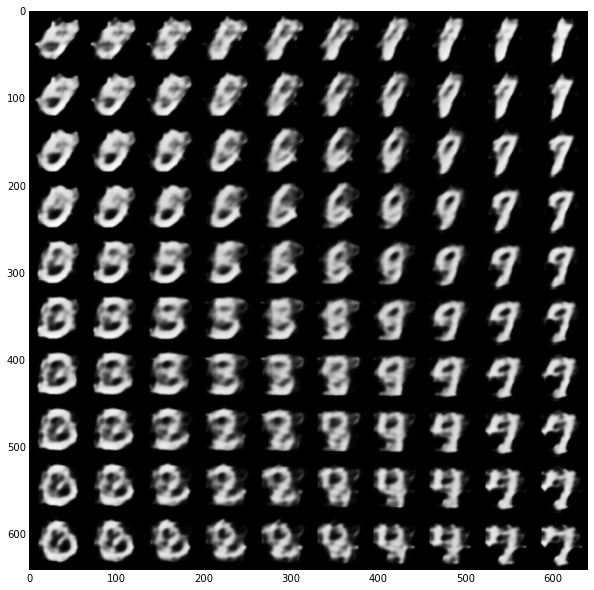

In [168]:
n = 10  # figure with 15x15 digits
digit_size = 64
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])*0.01
        z_sample=z_sample.astype(np.float32)
        x_decoded = _gen(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()